# Requirements

In [1]:
import numpy as np
import pandas as pd

from datasets import Dataset, load_dataset

from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizer
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB


import evaluate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

/Users/andrijanaarsovska/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Laboratory Exercise - Run Mode (8 points)

## Introduction
This laboratory assignment's primary objective is to fine-tune a pre-trained language model for binary classification on a dataset consisting of wine reviews. The dataset contains two attributes: **description** and **points**. The description is a brief text describing the wine and the points represent a quality metric ranging from 1 to 100. If some wine has at least 90 points it is considered **exceptional**. Your task involves predicting if some wine is **exceptional** based on its review.

## The Wine Reviews Dataset

Load the dataset using the `datasets` library.

In [34]:
#data = pd.read_csv('data/wine-reviews.csv')
from datasets import load_dataset

dataset = load_dataset("csv", data_files="data/wine-reviews.csv")
dataset


DatasetDict({
    train: Dataset({
        features: ['description', 'points'],
        num_rows: 10000
    })
})

In [35]:
df = dataset['train'].to_pandas()
df

,description,points
0,"Translucent in color, silky in the mouth, this...",85
1,"On the palate, this wine is rich and complex, ...",92
2,The producer blends 57% Chardonnay from the Ma...,92
3,"Pure Baga in all its glory, packed with dry an...",93
4,Think of Subsídio as a contribution rather tha...,89
...,...,...
9995,"From the folks at Merryvale, this is a blend o...",92
9996,"An easy, versatile food wine or cocktail sippe...",84
9997,Black-fruit aromas blend nicely into chocolate...,93
9998,"This combines 61% Cabernet Sauvignon, 14% Syra...",90


## Target Extraction
Extract the target **exceptional** for each wine review. If some wine has at least 90 points it is considered **exceptional**.

In [36]:
df['label'] = (df['points'] >= 90).astype(int)
labels = df['label']
len(labels)

10000

In [39]:
#dataset["train"] = dataset["train"].add_column("label", labels)
dataset['train'] = dataset['train'].remove_columns("points")
dataset = dataset.rename_column("description", "text")
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

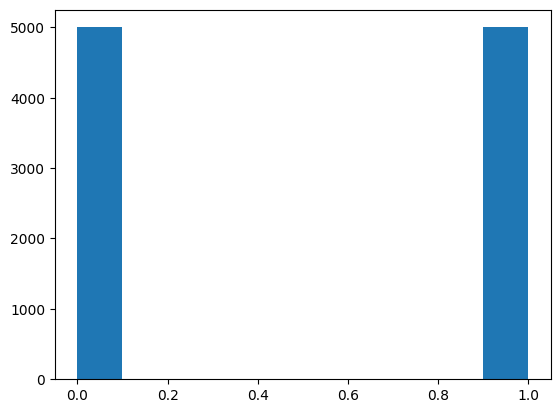

<bound method IndexOpsMixin.value_counts of 0       0
1       1
2       1
3       1
4       0
       ..
9995    1
9996    0
9997    1
9998    1
9999    1
Name: label, Length: 10000, dtype: int64>

In [40]:
import matplotlib.pyplot as plt

plt.hist(df['label'])
plt.show()

df['label'].value_counts

In [41]:
dataset['train'].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.


In [11]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data['description'], data['label'], test_size=0.2)

## Tokenization
Tokenize the texts using the `AutoTokenizer` class.

In [43]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


In [44]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [45]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map: 100%|████████████████████████| 2000/2000 [00:00<00:00, 18071.61 examples/s]


## Fine-tuning a Pre-trained Language Model for Classification
Fine-tune a pre-trained language model for classification on the given dataset.

Define the model using the `AutoModelForSequenceClassification` class.

In [47]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define the traning parameters using the `TrainingArguments` class.

In [48]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,  # batch size for evaluation
    metric_for_best_model="f1",
    num_train_epochs=1,
    learning_rate=0.001,
    # report_to="none",
)

Define the training using the `Trainer` class.

In [49]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [50]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

In [51]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [52]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)


Fine-tune (train) the pre-trained lanugage model.

In [54]:
#trainer.train()

Use the trained model to make predictions for the test set.

In [ ]:
trainer.evaluate()

In [ ]:
predictions = trainer.predict(tokenized_dataset["test"])

In [ ]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(labels, preds))

In [ ]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a simple machine learning pipeline to classify wine reviews as **exceptional** or not. Use TF-IDF vectorization to convert text into numerical features and train a logistic regression. Split the dataset into training and testing sets, fit the pipeline on the training data, and evaluate its performance using metrics such as precision, recall, and F1-score. Analyze the texts to find the most influential words or phrases associated with the **exceptional** wines. Use the coefficients from the logistic regression trained on TF-IDF features to identify the top positive and negative keywords for **exceptional** wines. Present these keywords in a simple table or visualization (e.g., bar chart).

In [55]:
df

,description,points,label
0,"Translucent in color, silky in the mouth, this...",85,0
1,"On the palate, this wine is rich and complex, ...",92,1
2,The producer blends 57% Chardonnay from the Ma...,92,1
3,"Pure Baga in all its glory, packed with dry an...",93,1
4,Think of Subsídio as a contribution rather tha...,89,0
...,...,...,...
9995,"From the folks at Merryvale, this is a blend o...",92,1
9996,"An easy, versatile food wine or cocktail sippe...",84,0
9997,Black-fruit aromas blend nicely into chocolate...,93,1
9998,"This combines 61% Cabernet Sauvignon, 14% Syra...",90,1


In [59]:
#df = df.drop('points', axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(df['description'],  df['label'], test_size=0.2)
df

,description,label
0,"Translucent in color, silky in the mouth, this...",0
1,"On the palate, this wine is rich and complex, ...",1
2,The producer blends 57% Chardonnay from the Ma...,1
3,"Pure Baga in all its glory, packed with dry an...",1
4,Think of Subsídio as a contribution rather tha...,0
...,...,...
9995,"From the folks at Merryvale, this is a blend o...",1
9996,"An easy, versatile food wine or cocktail sippe...",0
9997,Black-fruit aromas blend nicely into chocolate...,1
9998,"This combines 61% Cabernet Sauvignon, 14% Syra...",1


In [60]:
from collections import Counter

print(f"Training class distributions summary: {Counter(Y_train)}")
print(f"Test class distributions summary: {Counter(Y_test)}")
     

Training class distributions summary: Counter({1: 4039, 0: 3961})
Test class distributions summary: Counter({0: 1039, 1: 961})


In [61]:

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression


model = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

In [63]:
print("Classification Report:")
print(classification_report(Y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1039
           1       0.79      0.82      0.81       961

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000



In [64]:
#To analyze the most influential words or phrases associated with 
#exceptional wines and present them in a table or visualization, 
#we leverage the coefficients of the trained logistic regression model. 
#These coefficients indicate the importance
#of each word (feature) in predicting whether a wine is exceptional.

In [65]:
# 1. Extract Feature Names and Coefficients

vectorizer = model.named_steps['tfidfvectorizer']
logistic_model = model.named_steps['logisticregression']

feature_names = vectorizer.get_feature_names_out()
coefficients = logistic_model.coef_[0]

In [66]:
# 2. Sort Coefficients

#Sort the coefficients to identify the top positive and negative words.

top_positive_indices = np.argsort(coefficients)[-10:]  # Top 10 positive words
top_negative_indices = np.argsort(coefficients)[:10]   # Top 10 negative words

top_positive_keywords = [(feature_names[i], coefficients[i]) for i in top_positive_indices]
top_negative_keywords = [(feature_names[i], coefficients[i]) for i in top_negative_indices]


In [67]:
# 3. Prepare a Table

keywords, weights = zip(*top_positive_keywords + top_negative_keywords)
colors = ['green'] * len(top_positive_keywords) + ['red'] * len(top_negative_keywords)

# Create a table of top keywords
table_data = pd.DataFrame({
    'Keyword': [word for word, _ in top_positive_keywords + top_negative_keywords],
    'Coefficient': weights,
    'Type': ['Positive'] * len(top_positive_keywords) + ['Negative'] * len(top_negative_keywords)
})

In [68]:
print(table_data)

            Keyword  Coefficient      Type
0              rich     2.787649  Positive
1              lush     2.836156  Positive
2          vineyard     2.851792  Positive
3           elegant     2.968716  Positive
4             years     3.048284  Positive
5         beautiful     3.126384  Positive
6              2020     3.299394  Positive
7           complex     3.457170  Positive
8           through     3.852210  Positive
9              long     4.077740  Positive
10           simple    -3.368114  Negative
11             easy    -2.973883  Negative
12             soft    -2.888144  Negative
13           bitter    -2.490546  Negative
14  straightforward    -2.445657  Negative
15          flavors    -2.404203  Negative
16           fruity    -2.388319  Negative
17           medium    -2.338231  Negative
18           aromas    -2.247700  Negative
19              bit    -2.241285  Negative


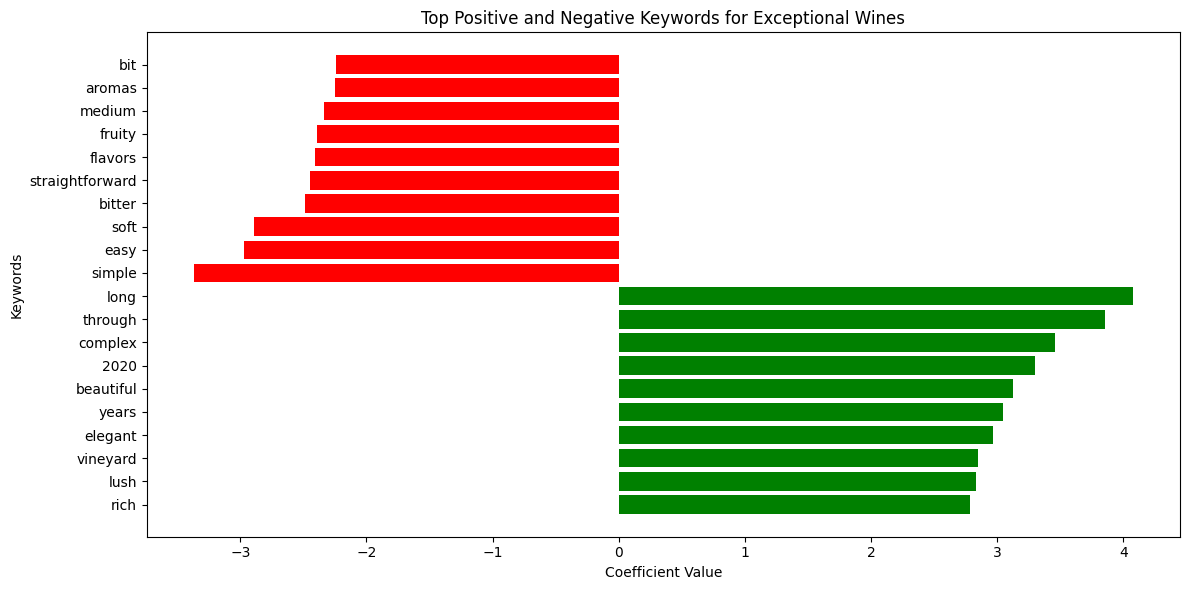

In [70]:
# 4. Create a Bar Chart
plt.figure(figsize=(12, 6))
plt.barh(keywords, weights, color=colors)
plt.title("Top Positive and Negative Keywords for Exceptional Wines")
plt.xlabel("Coefficient Value")
plt.ylabel("Keywords")
plt.tight_layout()
plt.show()